## Locality Sensitive Hashing (LSH)
(by Tevfik Aytekin)

### Approximate Nearest Neighbor

Finding nearest neighbors in a set of objects is a very general problem which has applications in many areas. If the size of the set of objects is very large then an exhaustive search can be very costly. In those cases approximate nearest neighbor techniques can be used. These techniques do not guarantee to find all the nearest neighbors but instead give some probabilistic guaranties. This implies that not all nearest neighbors will be returned and some not so nearest neigbors might appear in the returned list. But the gain is that these methods are much faster than their exhaustive versions. LSH is one such popular method.


### The main idea of LSH

The main idea of LSH is to design hash functions such that the probability of a collision is much higher for closer points compared to points which are far apart. Given such hash functions one can hash a query point and retrive the elements in the buckets that contain the query point.


### Formal Definition of LSH 
(following definition and figure is taken from [mmds book](http://www.mmds.org/) where you can read more about LSH)

Let $d_1 < d_2$ be two distances according to some distance measure $d$. A family $F$ of functions is said to be $(d_1, d_2, p_1, p_2)-sensitive$ if for every $f$ in $F$:
1. If $d(x,y) ≤ d_1$, then the probability that $f(x) = f(y)$ is at least $p_1$. 
2. If $d(x,y) ≥ d_2$, then the probability that $f(x) = f(y)$ is at most $p_2$.

In order for a LSH family to be useful: $p_1 > p_2$.

<img src="images/lsh.png" width = "400">

Once you have a family $F$ of functions we can amplify the gap between the $p_1$ and $p_2$ by AND and OR constructions. 

Suppose we are given a $(d_1, d_2, p_1, p_2)-sensitive$ family $F$. We can make an AND construction by building $g=(f_1,f_2,...,f_k)$ by choosing $k$ functions at random from $F$. We say that $g(x) = g(y)$ iff $g_i(x) = g_i(y)$ for all $i = 1, 2, . . . , k$.

We can make OR constructions by building $h=(g_1,f_2,...,g_l)$ by choosing $l$ functions from the set of $g$ functions as defined above. at random from $F$. Note that all the $f_i$'s in each $g_j$ are choosen at random from $F$. We define $h(x) = h(y)$ iff $g_i(x) = g_i(y)$ for one or more values of $i$. 

We assume a seperate hash table for each $g_i$. We will insert every point $p$ by the key $q_i(p)$ into each bucket of $g_i$'s during the build phase of LSH. When a query point $q$ comes we will return the elemements in the buckets at each $g_i(q)$


### An LSH Function for Cosine Similarity

For every distance metric (such as cosine, Jaccard, hamming, etc.) you should define a LSH family of hash functions (note that for some distance metrics this may not be possible). For cosine distance sign of the dot product of the data point with a random unit vector is used for construction the LSH. Each such random unit vector constitutes a different function in the LSH family F. The following figure illustrates why dot product with a random unit vector can be used to build an LSH family of function for cosine distance. 

<img src="images/lsh_cosine.jpg" width = "400">

In the above equation, $r$ is the random unit vector, $sign(r.a)$ is the sign of the dot product of $r$ and $a$. The equation gives the probability of the sign of the dot product of $r$ witg vectors $a$ and $b$. The figure above can be used for the proof. The arcs show the regions of $r$ where the dot product with $a$ or $b$ is positive. If $r$ is in the insersecting region $(180-\alpha)$ of the arcs then the signs will be the same. Hence we can conclude that the probability of this to happen is $\frac{180-\alpha}{180}$

But why does the above result show that we can build LSH family for cosine? Because as the distance between two vectors decreases (or equivalently as $\alpha$ decreases) the probability of a collusion increases, i.e., similar vectors have a higher probability of being mapped to the same hash bucket. 

In [1]:
import numpy as np
from scipy.spatial import distance
import time
from sklearn.metrics.pairwise import pairwise_distances
import itertools
import pandas as pd
import matplotlib.pyplot as plt


### Performance measurement

Nearest neighbor search: Suppose that we have a large dataset of vectors X and given a target vector we want to find the most similar k vectors to the target vector in the dataset X. Note that we can do this type of search more than once. 

First let us generate the dataset X:

In [2]:
n_vectors = 100000
dim = 10
n_neighbors = 100
n_queries = 2000

target_vectors = np.random.randn(n_queries, dim)
dataset = np.random.randn(n_vectors, dim)

### Naive search implementation

In [3]:
class NaiveSearch:
    def __init__(self, data):
        # data is a n-by-d matrix where d is the length of the vectors
        # and n is the number of vectors. 
        self.data = data
        self.norms = None
        self.data_normalized_T = None
    
        
    def build(self):
        self.norms = np.linalg.norm(self.data, axis=1)
        self.norms.shape = (len(self.norms), 1)
        
        data_normalized = np.divide(self.data, self.norms)
        self.data_normalized_T = data_normalized.T
            
            
    def find_nn(self, target_vector, n_neighbors=10):

        #target_vector_normalized = np.linalg.norm(target_vector)
        
        sims = np.dot(target_vector,self.data_normalized_T)[0]
        return sims.argsort()[::-1][:n_neighbors]


### LSH Implementation

In [2]:
class LSH:
    def __init__(self, data):
        # data is a n-by-d matrix where d is the length of the vectors
        # and n is the number of vectors. 
        self.data = data
        self.bands = []
        self.random_vectors = []
    
    def build(self, n_random_vectors, n_bands = 1):
        for b in range(n_bands):
            # generate random vectors
            self.bands.append({})
            dim = self.data.shape[1]
            self.random_vectors.append(np.random.randn(n_random_vectors, dim))
            # generate dim-by-n index bits
            sign_bits = np.dot(self.data, self.random_vectors[b].T) >= 0
            n_data_vectors = self.data.shape[0]
            for i in range(n_data_vectors):
                key = tuple(sign_bits[i,:])
                if key not in self.bands[b]:
                    self.bands[b][key] = []
                self.bands[b][key].append(i)
            
            
    def find_nn(self, target_vector, n_neighbors=10, n_bands = 1):

        candidate_ids = []
        for b in range(n_bands):
            sign_bits = (np.dot(target_vector, self.random_vectors[b].T) >= 0).flatten()
            sign_bits_tuple = tuple(sign_bits)
            ids = self.bands[b].get(sign_bits_tuple)
            if ids is None: 
                ids = []
            candidate_ids = candidate_ids + ids
        if len(candidate_ids) > 0:
            return candidate_ids
        
          # Instead of directly returning the candidates, you can compute teh similarities
          # between the target vector and all the candidates and eliminate false positives,
          # however this is a costly operation and will increase the running time. You can 
          # remove the following comments if you want to do that.
        
          # candidate_vectors = self.data[candidate_ids, :]
          # dists = pairwise_distances(target_vector, candidate_vectors, metric='cosine').flatten()
          # sorted_nn = dists.argsort()
          # return np.array([candidate_ids[i] for i in sorted_nn])
        else:
            return []

### Naive search experiment

In [5]:
ns = NaiveSearch(dataset)
tic = time.time()
ns.build()
ns_nn = []
for i in range(n_queries):
    target_vector = target_vectors[i,:].reshape(1,dim)
    neighbors = ns.find_nn(target_vector, n_neighbors)
    ns_nn.append(neighbors)
toc = time.time()
print("Time:"+str(1000*(toc-tic))+"ms")

Time:34539.71886634827ms


In [6]:
ns_nn[0]

array([39945, 20159, 92244, 70962, 49854, 66918,  1433, 67250, 57136,
       27247, 77254, 71009, 30105, 80930, 99196, 67559, 51576, 50549,
       17054, 70467, 43504, 61173, 55074,  1008, 98189, 25747, 58259,
       49744, 50669, 81468, 37720, 36590, 66527, 37263, 99373, 15511,
       79566, 95614, 60695, 12958, 71989, 19076, 68839, 94588,  3939,
       90688, 51628, 11099, 32739, 78411, 67766,  9541, 66261, 64511,
       72304, 31151, 83701,  8157, 62962, 96062,  4452, 47736, 92800,
       46818, 25385, 33200, 32193,  3234, 47114, 62808,  3326, 34019,
       10584, 44186, 50076, 57537, 68049, 77984,    73, 31632, 49907,
       96908, 97071, 88028, 92028, 60856, 73749, 22818, 23680, 47159,
       79847, 17845, 47280, 74925, 37911, 39458, 63023, 26876,  3473,
       53156])

### Naive search with sklearn

You can also implement naive search using pairwise_distances() function.

In [7]:
tic = time.time()
dists = pairwise_distances(target_vectors, dataset, metric='cosine')
ns_nn = []
for i in range(n_queries):
    neighbors = dists[i,:].argsort()[:n_neighbors]
    ns_nn.append(neighbors)
toc = time.time()
print("Time:"+str(1000*(toc-tic))+"ms")

Time:23932.0547580719ms


In [ ]:
ns_nn[0]

array([10439, 54436, 78849, 53593, 24455, 89676, 44299, 21832, 56687,
       65730,  2852, 35671, 68547, 47210, 57942, 57735, 97698, 50668,
       13380, 16457, 55733,  3666,  8721, 99667, 68002, 78029, 94636,
       32779, 67252, 11524, 42685,  5310, 94430, 18126, 45511, 77286,
       90569, 70094, 48794, 64874, 72855,  6964, 29542, 90611, 88491,
       89829, 94639, 74306, 10612, 66092, 66337, 27164, 27674, 85264,
           9, 64308, 85051, 39242, 48933, 90441, 63177, 45489,  2158,
       14244, 33535,  9323, 94899, 48293, 92453, 64798, 48665, 48225,
       30825,  3538, 61981,  8050, 63390, 64541, 32341,  8218, 38162,
       17382, 29835, 83302, 96494, 89437, 55249, 37937, 60825, 32079,
       73536, 54711, 81008, 77465, 85432, 44119, 89734,   428, 49543,
        8488])

### Analysis of the main parameters of LSH

The are two main parameters of the LSH technique: the number of hash tables (bands) and the size of signatures (rows). The following figure shows an example where we have 4 bands and the signature size is 3. One can see that in band 1 columns 2 and 4 have identical signatures (101). So, the items corresponding to these columns will map into the same bucket. The signatures of items 1 and 2 in band 1 are not identical but in band 2 they are identical. So, they will map to the same bucket in the hash table corresponding to band 2. 


<table border=1>
    <tr>
        <td>Band 1</td>
        <td>01010 ...<br>00001 ...<br>01110 ...</td>
    </tr>
    <tr>
        <td>Band 2</td>
        <td>11010 ...<br>11011 ...<br>00100 ...</td>
    </tr>
    <tr>
        <td>Band 3</td>
        <td>01110 ...<br>10001 ...<br>00111 ...</td>
    </tr>
    <tr>
        <td>Band 4</td>
        <td>11000 ...<br>10010 ...<br>00111 ...</td>
    </tr>
</table>

There can be to types of errors: false positives and false negatives. False positives are cases where two dissimilar items map to the same bucket. False negatives are cases where two similar items map to different buckets. As the number of bands increases the possibility of false negatives will decrease and as the size of the signatures increases the possiblity of false positives will decreases.
 
By changing the values of $b$ (number og bands) and $r$ (number of rows) one can adjust the ratio of false negatives and false positives. Given that the probability of the signature values of two items to agree in any one particular row is $s$, the probability of becoming a candidate pair is $1 - (1 - s^r)^b$ which can be calculated as below:

Given two items:

- The probability that signatures agree in all rows of a particular band is $s^r$
- The probability that signatures disagree in at least one row of a particular band is $1-s^r$
- The probability that signatures disagree in at least one row of each of the bands is ($1-s^r)^b$
- The probability that signatures agree in all rows of at least one band (that is, they become a candidate pair is $1 - (1 - s^r)^b$

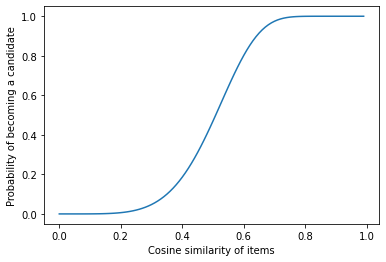

In [8]:
def prob_cand_func(b, r):
    return 1 - (1-s**r)**b
r = 5
b = 20

s = np.arange(0,1,0.01)
plt.plot(s, prob_cand_func(b, r))
plt.ylabel("Probability of becoming a candidate")
plt.xlabel("Cosine similarity of items");

### LSH experiment

This experiment runs LSH with different number of bands and rows. Here, each random vector corresponds to a different row. In the end of the experiment, time, recall, and avg. neighbor list sizes are shown for each value of number of bands and rows. Time is the time to return the neighbors from the LSH data structure (build time of LSH is not included). Recall is the ratio of items that are returned by LSH in the true nearest neighbor list (of size n_neighbors). Avg. neighbor list size is the average size of the lists returned by LSH.

In [9]:
min_n_random_vectors = 15
max_n_random_vectors = 20
max_n_bands = 10
min_n_bands = 5


elapsed_time = np.zeros((max_n_bands-min_n_bands+1, (max_n_random_vectors-min_n_random_vectors)+1))
recall = np.zeros((max_n_bands-min_n_bands+1, (max_n_random_vectors-min_n_random_vectors)+1))
avg_neigbor_size = np.zeros((max_n_bands-min_n_bands+1, (max_n_random_vectors-min_n_random_vectors)+1))

for b in range(min_n_bands, max_n_bands+1):
    for v in range(min_n_random_vectors,max_n_random_vectors+1):
        lsh_nn = []
        lsh = LSH(dataset)
        lsh.build(v, n_bands = b)
        tic = time.process_time()
        for i in range(n_queries):
            target_vector = target_vectors[i,:].reshape(1,dim)
            neighbors = lsh.find_nn(target_vector, n_neighbors, n_bands = b)
            lsh_nn.append(neighbors)
        toc = time.process_time()
        elapsed_time[b-min_n_bands,v-min_n_random_vectors] = (toc-tic)*1000
        true_positives = sum([len(np.intersect1d(ns_nn[i], lsh_nn[i][:n_neighbors])) for i in range(n_queries)])
        recall[b-min_n_bands,v-min_n_random_vectors] = true_positives / (n_queries*n_neighbors)
        avg_neigbor_size[b-min_n_bands,v-min_n_random_vectors] = len(list(itertools.chain(*lsh_nn)))/n_queries
    


elapsed_time_df = pd.DataFrame(elapsed_time)
recall_df = pd.DataFrame(recall)
avg_neigbor_size_df = pd.DataFrame(avg_neigbor_size)

row_names = [str(i) for i in range(min_n_bands, max_n_bands+1)]
column_names = [str(i) for i in range(min_n_random_vectors, max_n_random_vectors+1)]
elapsed_time_df.columns = recall_df.columns =avg_neigbor_size_df.columns = column_names
elapsed_time_df.index = recall_df.index = avg_neigbor_size_df.index = row_names
print("Elapsed Time")
display(elapsed_time_df)
print("Recall")
display(recall_df)
print("Avg. Neighbor Size")
display(avg_neigbor_size_df)

Elapsed Time


,15,16,17,18,19,20
5,172.657396,162.929195,134.042511,131.186801,123.045127,117.802020
6,194.488131,171.768996,167.244920,177.617960,144.982617,136.461200
7,238.982570,224.446163,202.729192,193.505360,167.157542,182.287301
8,273.287026,272.894180,254.975012,239.264371,250.079959,221.572495
9,334.879220,328.777047,234.192605,242.354065,272.588333,281.777832
10,353.744032,316.333679,271.472006,286.190435,239.563609,252.811587


Recall


,15,16,17,18,19,20
5,0.108655,0.124285,0.124275,0.120280,0.114755,0.106285
6,0.111805,0.122185,0.126210,0.127760,0.131875,0.123320
7,0.118140,0.114110,0.131620,0.139025,0.147315,0.137185
8,0.116300,0.118005,0.139145,0.153210,0.157525,0.146910
9,0.108055,0.118680,0.156230,0.150410,0.155355,0.160580
10,0.122000,0.128925,0.141925,0.161975,0.168920,0.160420


Avg. Neighbor Size


,15,16,17,18,19,20
5,342.6730,219.6640,163.1385,134.4395,92.4055,58.6285
6,354.1365,252.8145,224.1780,176.9175,109.4245,77.8560
7,402.7620,392.0520,297.9605,171.5775,107.6455,88.1355
8,440.4385,383.0130,260.8130,185.0715,133.0765,110.2310
9,637.1600,431.0375,242.4765,226.9565,169.5185,95.3185
10,521.9620,391.6120,276.3415,207.4040,155.2675,134.8195


### Single LSH experiment

Below is a single LSH experiment with a fixed value for n_bands and n_random_vectors.

In [3]:
n_random_vectors = 20
n_bands = 5

lsh_nn = []
lsh = LSH(dataset)
lsh.build(n_random_vectors = n_random_vectors, n_bands = n_bands)
tic = time.process_time()
for i in range(n_queries):
    target_vector = target_vectors[i,:].reshape(1,dim)
    neighbors = lsh.find_nn(target_vector, n_neighbors, n_bands = n_bands)
    lsh_nn.append(neighbors)
toc = time.process_time()
print("Elapsed Time: "+str(1000*(toc-tic))+"ms")
true_positives = sum([len(np.intersect1d(ns_nn[i], lsh_nn[i][:n_neighbors])) for i in range(n_queries)])
print("Recall: "+str(true_positives / (n_queries*n_neighbors)))
print("Avg neigbor size: "+ str(len(list(itertools.chain(*lsh_nn)))/n_queries))


NameError: ignored

### A note on running time comparison

In the above implementations you can find both the exhaustive and LSH-based search experiments. But one should be careful when evaluating the running times of these experiments. The dominating cost in exhaustive search is the matrix multiplication operation which is done using numpy's dot() function which implemented in C. So the above running time results do not reflect the true capacity of LSH (which should be better). In order to make a fair comparison it would be better to write everything in C/C++.